# Employee Attrition Analysis – Modeling

This notebook builds classification models to predict employee attrition using the IBM HR Analytics dataset.

In [1]:
# Cell 1: Imports
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import joblib

plt.style.use("seaborn-v0_8-darkgrid")
sns.set(font_scale=1.0)

In [2]:
# Cell 2: Load data
# Prefer the cleaned EDA file if it exists; otherwise load the Excel directly
import os

if os.path.exists("employee_attrition_eda_clean.csv"):
    df = pd.read_csv("employee_attrition_eda_clean.csv")
    print("Loaded employee_attrition_eda_clean.csv")
else:
    df = pd.read_excel("IBM_HR_Analytics.xlsx")
    print("Loaded IBM_HR_Analytics.xlsx")

print("Shape:", df.shape)
df.head()

Loaded employee_attrition_eda_clean.csv
Shape: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
# Cell 3: Basic cleaning and target encoding

# Drop obvious identifier columns if present
id_like_cols = [
    "EmployeeNumber", "EmployeeCount", "Over18", "StandardHours", "EmployeeID", "ID"
]
for c in id_like_cols:
    if c in df.columns:
        df = df.drop(columns=[c])

# Ensure Attrition exists and encode it
if "Attrition" not in df.columns:
    raise ValueError("Column 'Attrition' not found in dataset.")

# Map Attrition to binary flag
df["Attrition"] = df["Attrition"].astype(str)
df["Attrition_Flag"] = df["Attrition"].map({"Yes": 1, "No": 0})

print(df[["Attrition", "Attrition_Flag"]].head())

  Attrition  Attrition_Flag
0       Yes               1
1        No               0
2       Yes               1
3        No               0
4        No               0


In [4]:
# Cell 4: Define features (X) and target (y)

y = df["Attrition_Flag"]
X = df.drop(columns=["Attrition", "Attrition_Flag"])

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (1470, 30)
Target shape: (1470,)


In [5]:
# Cell 5: One-hot encode categorical variables

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
print("Categorical columns to encode:", cat_cols)

X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

print("Encoded feature shape:", X_encoded.shape)
X_encoded.head()

Categorical columns to encode: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
Encoded feature shape: (1470, 44)


,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,1102,1,2,2,94,3,2,4,5993,...,False,False,False,False,False,True,False,False,True,True
1,49,279,8,1,3,61,2,2,2,5130,...,False,False,False,False,True,False,False,True,False,False
2,37,1373,2,2,4,92,2,1,3,2090,...,True,False,False,False,False,False,False,False,True,True
3,33,1392,3,4,4,56,3,1,3,2909,...,False,False,False,False,True,False,False,True,False,True
4,27,591,2,1,1,40,3,1,2,3468,...,True,False,False,False,False,False,False,True,False,False


In [6]:
# Cell 6: Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (1176, 44)
Test shape: (294, 44)


In [7]:
# Cell 7: Feature scaling (for models that need it)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

=== Logistic Regression ===
Accuracy: 0.8605442176870748
ROC-AUC: 0.8079076578516668

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       247
           1       0.62      0.34      0.44        47

    accuracy                           0.86       294
   macro avg       0.75      0.65      0.68       294
weighted avg       0.84      0.86      0.84       294



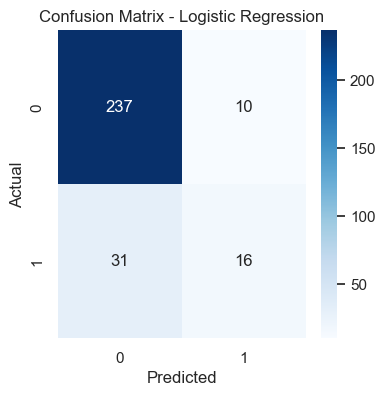

In [8]:
# Cell 8: Logistic Regression model

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
log_pred = log_reg.predict(X_test_scaled)

print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, log_pred))
print("ROC-AUC:", roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:, 1]))
print("\nClassification Report:\n", classification_report(y_test, log_pred))

cm_log = confusion_matrix(y_test, log_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

=== Random Forest ===
Accuracy: 0.8435374149659864
ROC-AUC: 0.7809458178999052

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.99      0.91       247
           1       0.57      0.09      0.15        47

    accuracy                           0.84       294
   macro avg       0.71      0.54      0.53       294
weighted avg       0.81      0.84      0.79       294



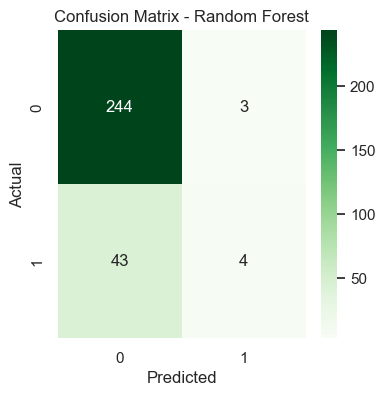

In [9]:
# Cell 9: Random Forest model

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced"
)
rf.fit(X_train, y_train)  # tree-based models can work on unscaled data
rf_pred = rf.predict(X_test)

print("=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))
print("\nClassification Report:\n", classification_report(y_test, rf_pred))

cm_rf = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

=== Gradient Boosting ===
Accuracy: 0.8503401360544217
ROC-AUC: 0.7941252476526832

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92       247
           1       0.59      0.21      0.31        47

    accuracy                           0.85       294
   macro avg       0.73      0.59      0.61       294
weighted avg       0.82      0.85      0.82       294



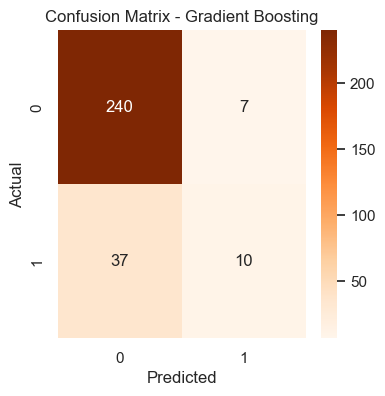

In [10]:
# Cell 10: Gradient Boosting model

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)

print("=== Gradient Boosting ===")
print("Accuracy:", accuracy_score(y_test, gb_pred))
print("ROC-AUC:", roc_auc_score(y_test, gb.predict_proba(X_test)[:, 1]))
print("\nClassification Report:\n", classification_report(y_test, gb_pred))

cm_gb = confusion_matrix(y_test, gb_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm_gb, annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

                 Model  Accuracy   ROC_AUC
0  Logistic Regression  0.860544  0.807908
1        Random Forest  0.843537  0.780946
2    Gradient Boosting  0.850340  0.794125


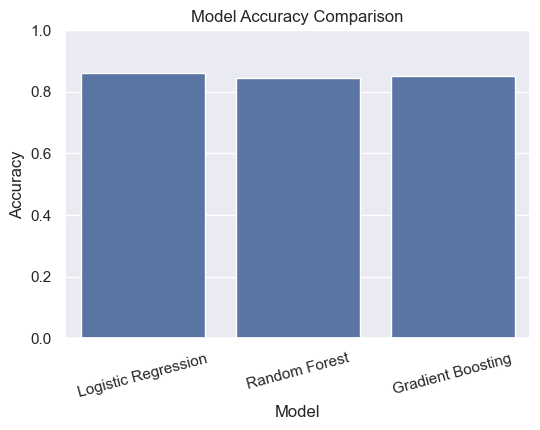

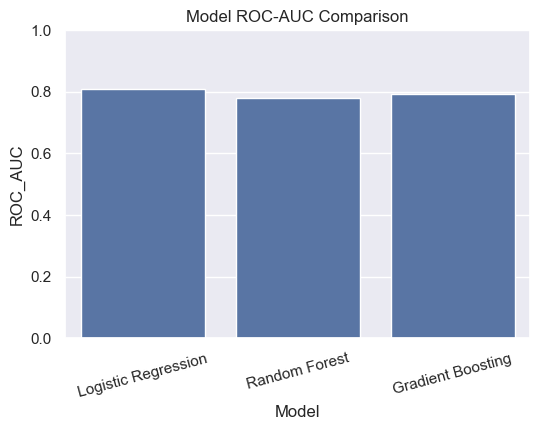

In [11]:
# Cell 11: Compare model performance

models = ["Logistic Regression", "Random Forest", "Gradient Boosting"]

acc_scores = [
    accuracy_score(y_test, log_pred),
    accuracy_score(y_test, rf_pred),
    accuracy_score(y_test, gb_pred)
]

roc_scores = [
    roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:, 1]),
    roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]),
    roc_auc_score(y_test, gb.predict_proba(X_test)[:, 1])
]

results_df = pd.DataFrame({
    "Model": models,
    "Accuracy": acc_scores,
    "ROC_AUC": roc_scores
})

print(results_df)

plt.figure(figsize=(6,4))
sns.barplot(data=results_df, x="Model", y="Accuracy")
plt.ylim(0,1)
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=15)
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(data=results_df, x="Model", y="ROC_AUC")
plt.ylim(0,1)
plt.title("Model ROC-AUC Comparison")
plt.xticks(rotation=15)
plt.show()

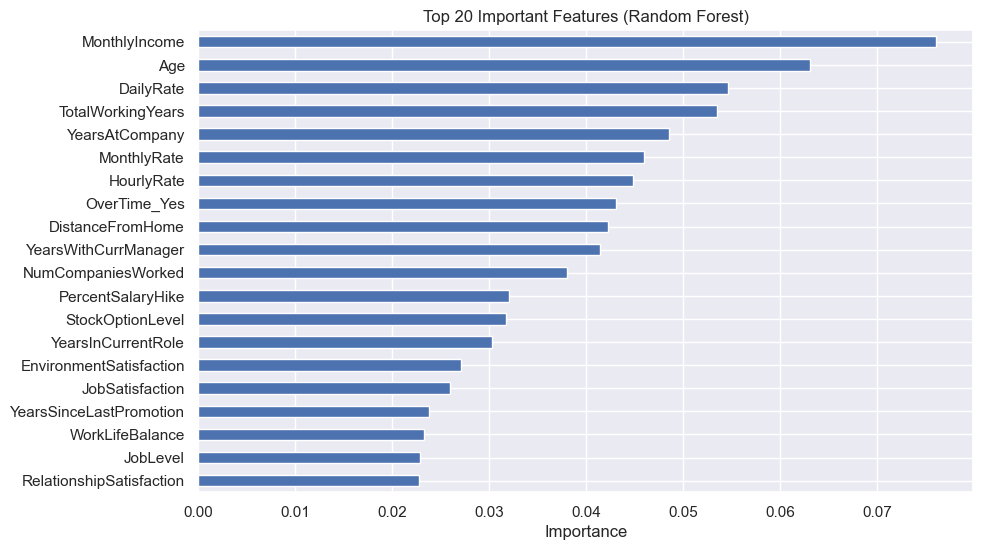

In [12]:
# Cell 12: Feature importance from Random Forest

importances = rf.feature_importances_
feat_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_importances.head(20).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 20 Important Features (Random Forest)")
plt.xlabel("Importance")
plt.show()

In [13]:
# Cell 13: Save the best model and scaler

# Choose best model based on ROC-AUC (you can change this decision manually)

best_model = gb  # assume Gradient Boosting performs best

joblib.dump(scaler, "attrition_scaler.pkl")
joblib.dump(best_model, "attrition_model.pkl")
print("Saved scaler as attrition_scaler.pkl and model as attrition_model.pkl")

Saved scaler as attrition_scaler.pkl and model as attrition_model.pkl


In [14]:
# Cell 14: Example – load model and predict on new data

loaded_scaler = joblib.load("attrition_scaler.pkl")
loaded_model = joblib.load("attrition_model.pkl")

# Take a small sample from X for demonstration
sample = X.head(5)

# One-hot encode sample in the same way as training data
sample_encoded = pd.get_dummies(sample, columns=cat_cols, drop_first=True)

# Align columns with training data
sample_encoded = sample_encoded.reindex(columns=X_train.columns, fill_value=0)

sample_scaled = loaded_scaler.transform(sample_encoded)

sample_pred = loaded_model.predict(sample_scaled)
sample_prob = loaded_model.predict_proba(sample_scaled)[:, 1]

print("Sample predictions (1=Attrition, 0=No Attrition):", sample_pred)
print("Predicted probabilities of Attrition:", sample_prob)

Sample predictions (1=Attrition, 0=No Attrition): [1 1 1 1 1]
Predicted probabilities of Attrition: [0.99952787 0.88898396 0.99892122 0.99118695 0.99289559]


c:\Users\kunal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\kunal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
